<a href="https://colab.research.google.com/github/Tej3424/Plant-Disease/blob/main/plant_disease_classification_fine_tuned_99_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix
# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
100% 2.70G/2.70G [01:12<00:00, 43.4MB/s]
100% 2.70G/2.70G [01:12<00:00, 39.9MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("new-plant-diseases-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("/content/new-plant-diseases-dataset")

# Loading Dataset

In [ ]:
dataset = {
             "train_data" : "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
             "valid_data" : "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
             "test_data" : "/content/new-plant-diseases-dataset/test"
          }
all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
    all_data.append(data.copy())
    data.clear()
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))
#Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])



In [ ]:
valid_df , test_df = train_test_split(valid_df ,  train_size= 0.90 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


# Traing Data images count per class

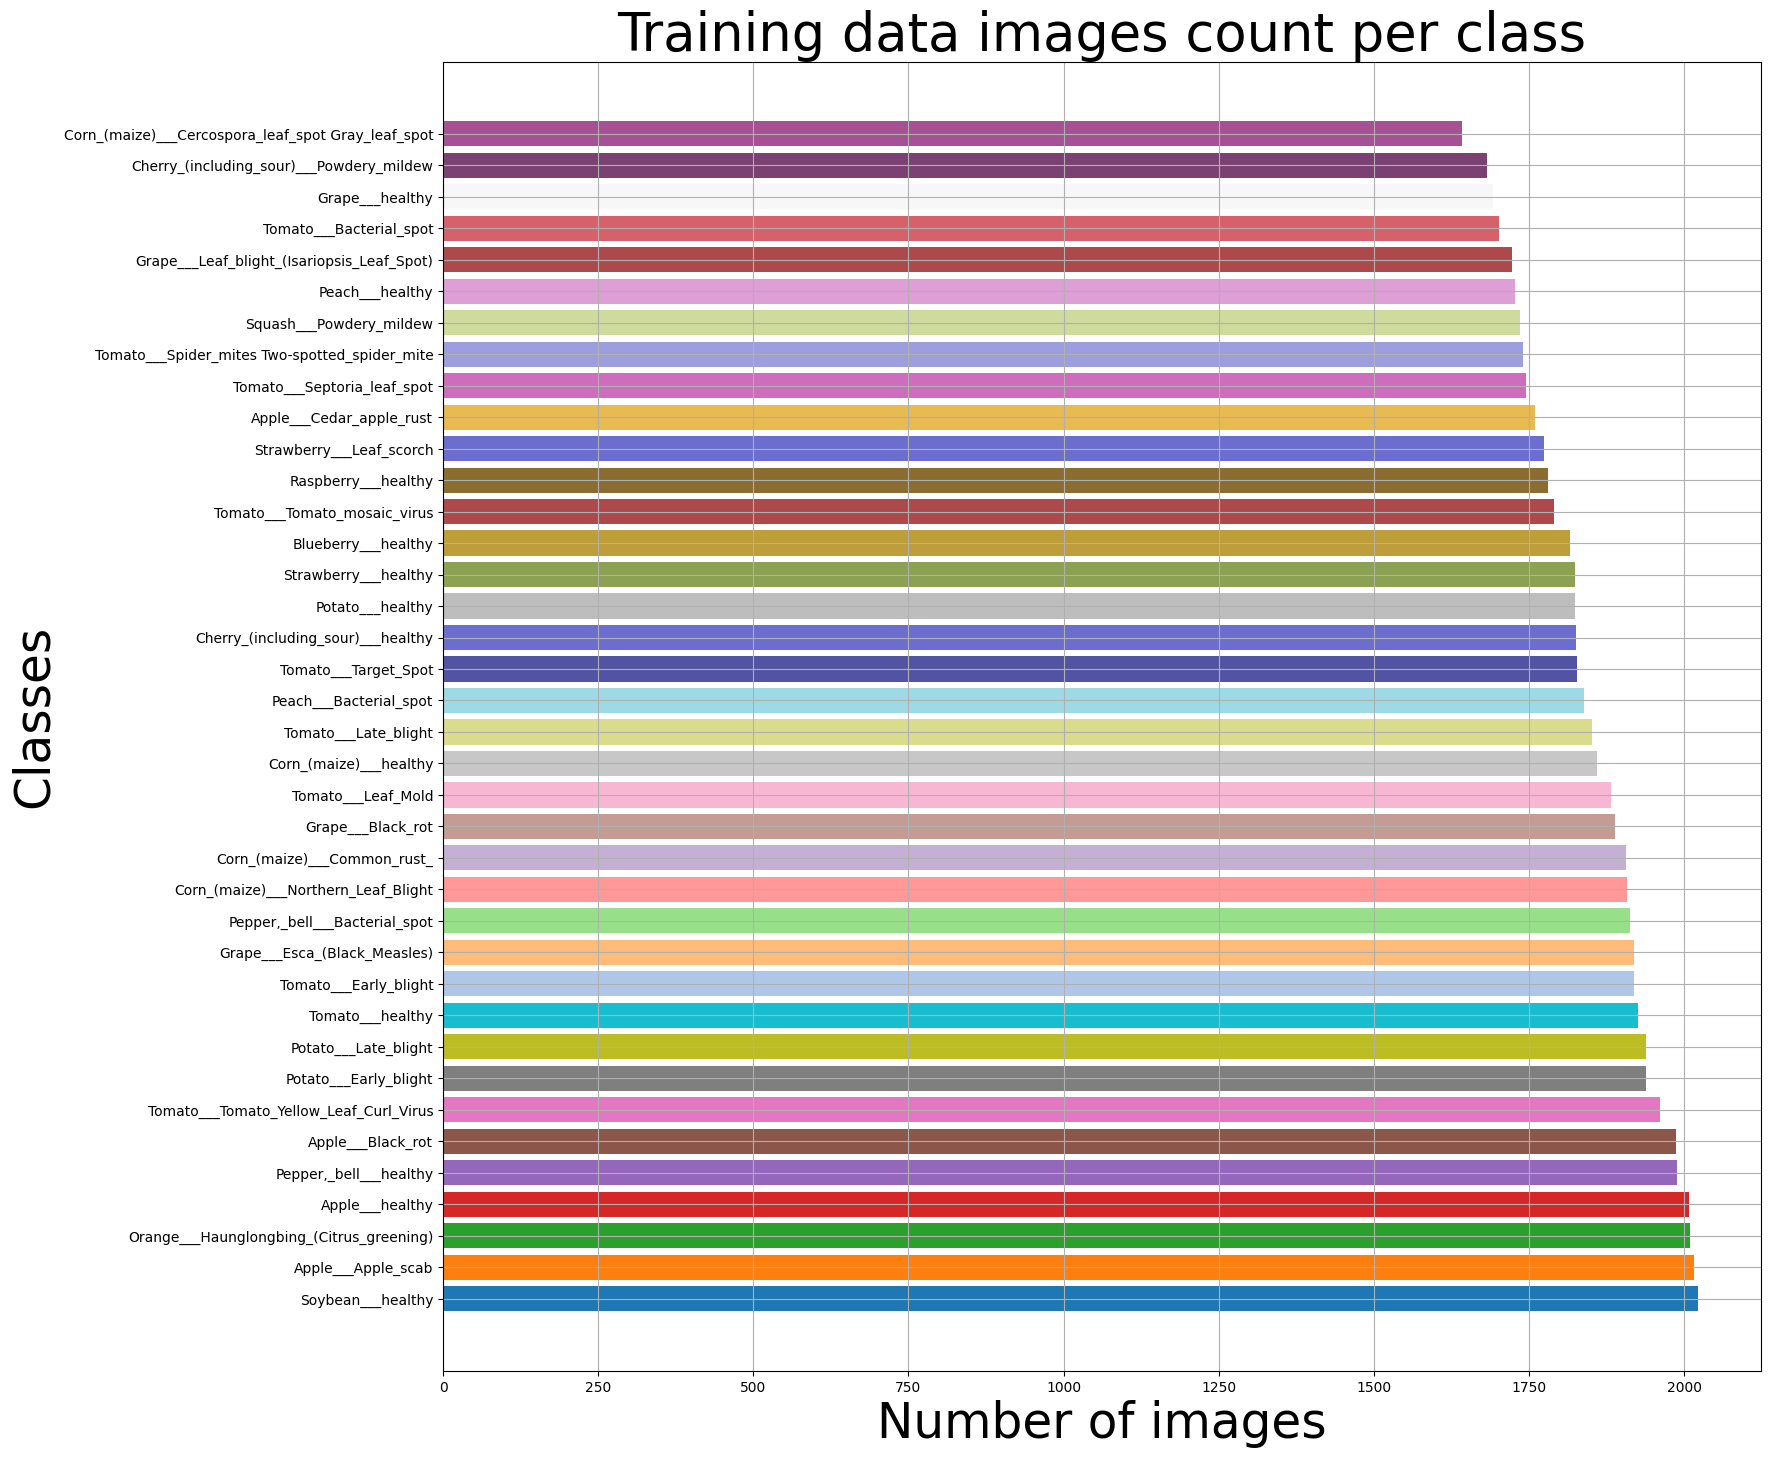

In [ ]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [ ]:
train_df.sample(n=15, random_state=1)

imgpath  \
59490  /content/new-plant-diseases-dataset/New Plant ...   
58840  /content/new-plant-diseases-dataset/New Plant ...   
11750  /content/new-plant-diseases-dataset/New Plant ...   
19617  /content/new-plant-diseases-dataset/New Plant ...   
48429  /content/new-plant-diseases-dataset/New Plant ...   
46935  /content/new-plant-diseases-dataset/New Plant ...   
42758  /content/new-plant-diseases-dataset/New Plant ...   
33007  /content/new-plant-diseases-dataset/New Plant ...   
42522  /content/new-plant-diseases-dataset/New Plant ...   
43380  /content/new-plant-diseases-dataset/New Plant ...   
59502  /content/new-plant-diseases-dataset/New Plant ...   
61584  /content/new-plant-diseases-dataset/New Plant ...   
49104  /content/new-plant-diseases-dataset/New Plant ...   
58274  /content/new-plant-diseases-dataset/New Plant ...   
53481  /content/new-plant-diseases-dataset/New Plant ...   

                                                  labels  encoded_labels  
59490                             Peach___Bacterial_spot              16  
58840                                   Potato___healthy              22  
11750                               Tomato___Late_blight              30  
19617                                  Soybean___healthy              24  
48429                                 Apple___Apple_scab               0  
46935  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...               7  
42758                           Strawberry___Leaf_scorch              26  
33007                            Squash___Powdery_mildew              25  
42522                           Strawberry___Leaf_scorch              26  
43380                           Strawberry___Leaf_scorch              26  
59502                             Peach___Bacterial_spot              16  
61584                       Grape___Esca_(Black_Measles)              12  
49104                                 Apple___Apple_scab               0  
58274                                   Potato___healthy              22  
53481                             Corn_(maize)___healthy              10

In [ ]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath              labels
0  /content/new-plant-diseases-dataset/New Plant ...  Tomato___Leaf_Mold
1  /content/new-plant-diseases-dataset/New Plant ...  Tomato___Leaf_Mold
2  /content/new-plant-diseases-dataset/New Plant ...  Tomato___Leaf_Mold
3  /content/new-plant-diseases-dataset/New Plant ...  Tomato___Leaf_Mold
4  /content/new-plant-diseases-dataset/New Plant ...  Tomato___Leaf_Mold
(70295, 3)
--------Validation----------
                                             imgpath  \
0  /content/new-plant-diseases-dataset/New Plant ...   
1  /content/new-plant-diseases-dataset/New Plant ...   
2  /content/new-plant-diseases-dataset/New Plant ...   
3  /content/new-plant-diseases-dataset/New Plant ...   
4  /content/new-plant-diseases-dataset/New Plant ...   

                                   labels  
0                         Peach___healthy  
1            Grape___Esca_(Black_Measles)  
2                  Peach

# Show sample from data

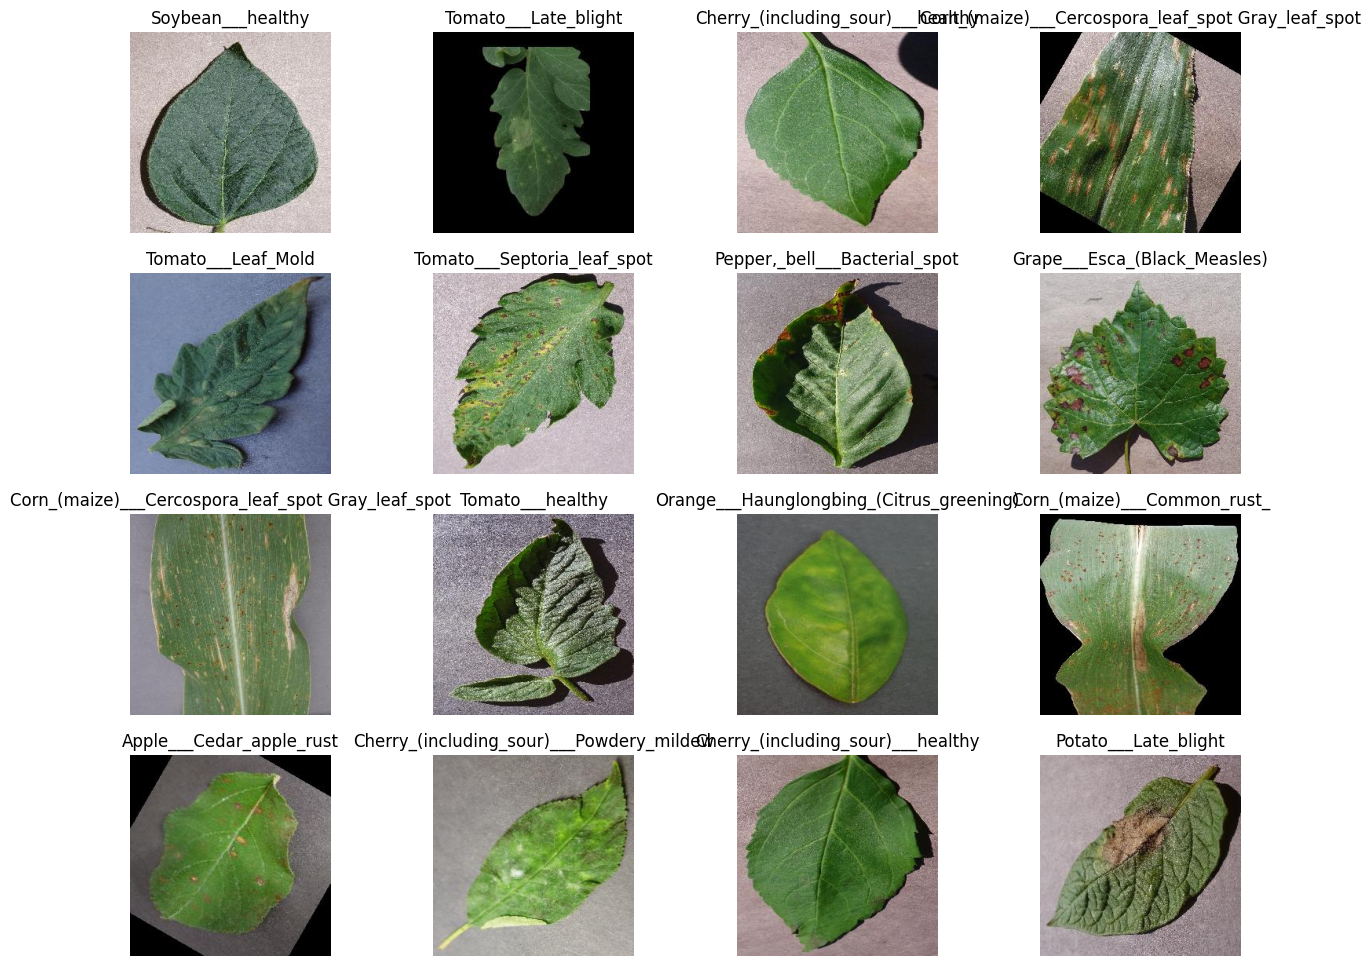

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [ ]:
%%time

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 70295 validated image filenames belonging to 38 classes.
Found 15814 validated image filenames belonging to 38 classes.
Found 1758 validated image filenames belonging to 38 classes.
CPU times: user 497 ms, sys: 350 ms, total: 847 ms
Wall time: 870 ms


# Model Structure

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

115263384/115263384 [==============================] - 3s 0us/step


# Training : Transfer Learning

In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  

In [ ]:

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
2197/2197 [==============================] - 362s 153ms/step - loss: 0.8128 - accuracy: 0.7761 - val_loss: 0.6692 - val_accuracy: 0.7884 - lr: 5.0000e-04
Epoch 2/10
2197/2197 [==============================] - 328s 149ms/step - loss: 0.4657 - accuracy: 0.8600 - val_loss: 0.5245 - val_accuracy: 0.8286 - lr: 5.0000e-04
Epoch 3/10
2197/2197 [==============================] - 356s 162ms/step - loss: 0.4129 - accuracy: 0.8728 - val_loss: 0.4104 - val_accuracy: 0.8676 - lr: 5.0000e-04
Epoch 4/10
2197/2197 [==============================] - 356s 162ms/step - loss: 0.3983 - accuracy: 0.8773 - val_loss: 0.4320 - val_accuracy: 0.8549 - lr: 5.0000e-04
Epoch 5/10
2197/2197 [==============================] - 331s 151ms/step - loss: 0.3826 - accuracy: 0.8799 - val_loss: 0.3907 - val_accuracy: 0.8752 - lr: 5.0000e-04
Epoch 6/10
2197/2197 [==============================] - 330s 150ms/step - loss: 0.3839 - accuracy: 0.8801 - val_loss: 0.3145 - val_accuracy: 0.9002 - lr: 5.0000e-04
Epoch 7/10

# Display model performance

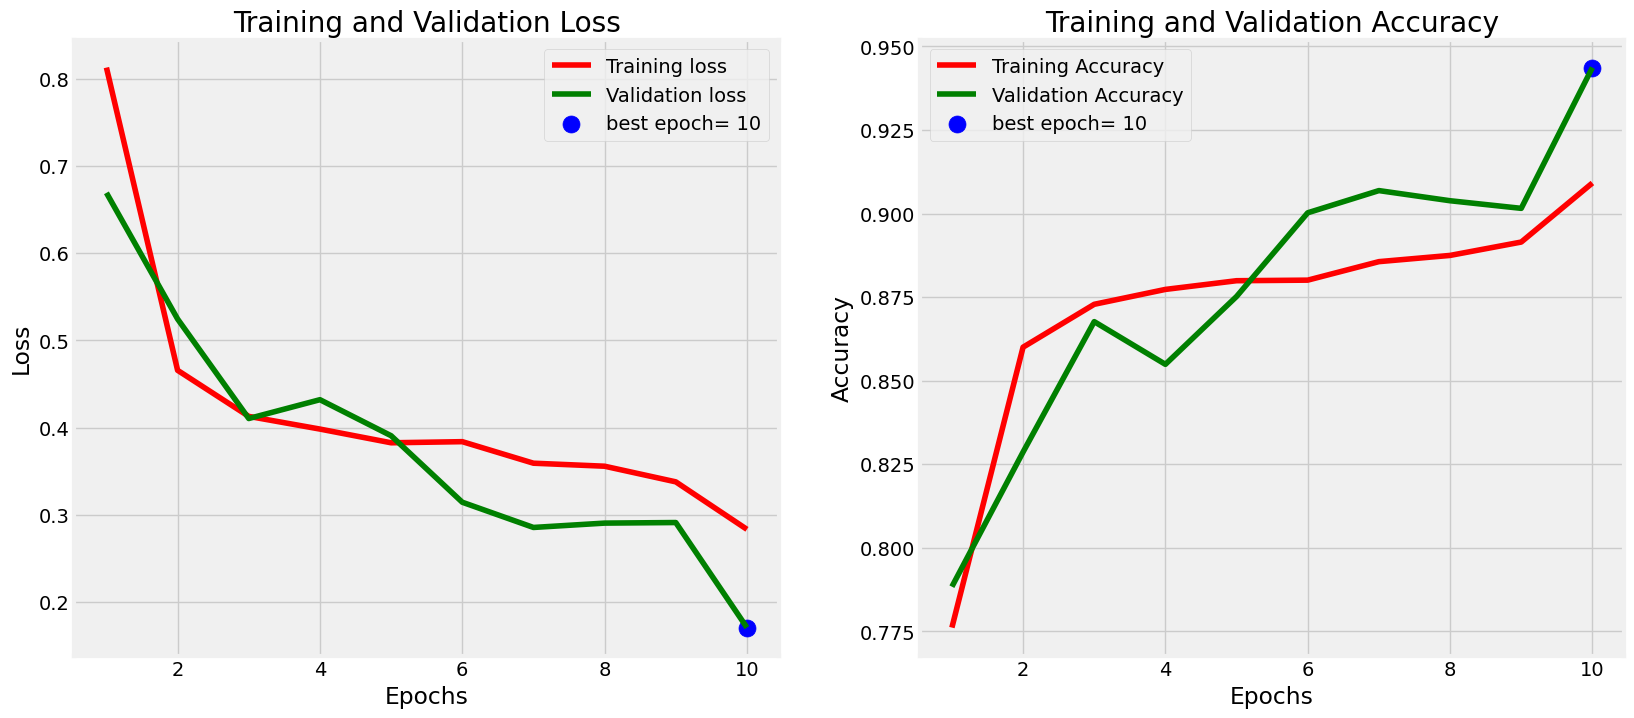

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=3,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation (Activation

# Display model performance

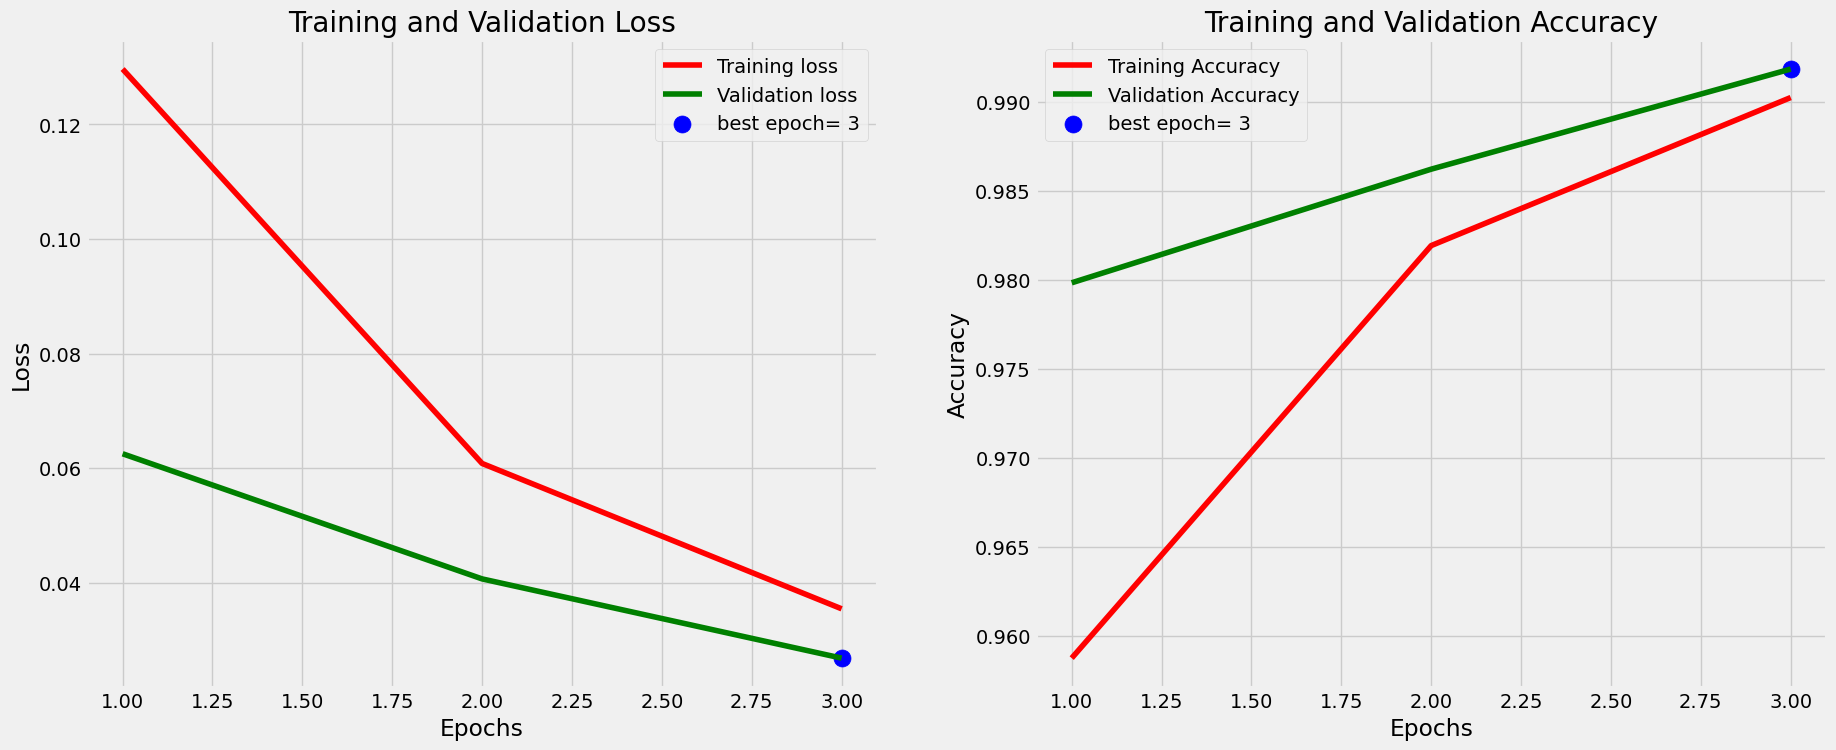

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.03062
Test Accuracy: 99.03%


# F1 Score / Recall / Precision

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

55/55 [==============================] - 10s 112ms/step
F1 Score: 0.9904013349538114
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.98      0.99        51
                                 Apple___Black_rot       0.98      1.00      0.99        43
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        33
                                   Apple___healthy       1.00      0.98      0.99        47
                               Blueberry___healthy       1.00      1.00      1.00        40
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        39
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        60
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      1.00      0.97        42
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00     

# Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

55/55 [==============================] - 6s 110ms/step


Image Index  Test Labels            Test Classes  Prediction Labels  \
0            0           11       Grape___Black_rot                 11   
1            1           10  Corn_(maize)___healthy                 10   
2            2           27    Strawberry___healthy                 27   
3            3           37        Tomato___healthy                 37   
4            4           16  Peach___Bacterial_spot                 16   
5            5           29   Tomato___Early_blight                 29   
6            6           16  Peach___Bacterial_spot                 16   
7            7           23     Raspberry___healthy                 23   

       Prediction Classes                                               Path  \
0       Grape___Black_rot  /content/new-plant-diseases-dataset/New Plant ...   
1  Corn_(maize)___healthy  /content/new-plant-diseases-dataset/New Plant ...   
2    Strawberry___healthy  /content/new-plant-diseases-dataset/New Plant ...   
3        Tomato___healthy  /content/new-plant-diseases-dataset/New Plant ...   
4  Peach___Bacterial_spot  /content/new-plant-diseases-dataset/New Plant ...   
5   Tomato___Early_blight  /content/new-plant-diseases-dataset/New Plant ...   
6  Peach___Bacterial_spot  /content/new-plant-diseases-dataset/New Plant ...   
7     Raspberry___healthy  /content/new-plant-diseases-dataset/New Plant ...   

   Prediction Probability  
0                0.998665  
1                0.999999  
2                0.999649  
3                0.993707  
4                0.999890  
5                0.980721  
6                0.983168  
7                0.999988

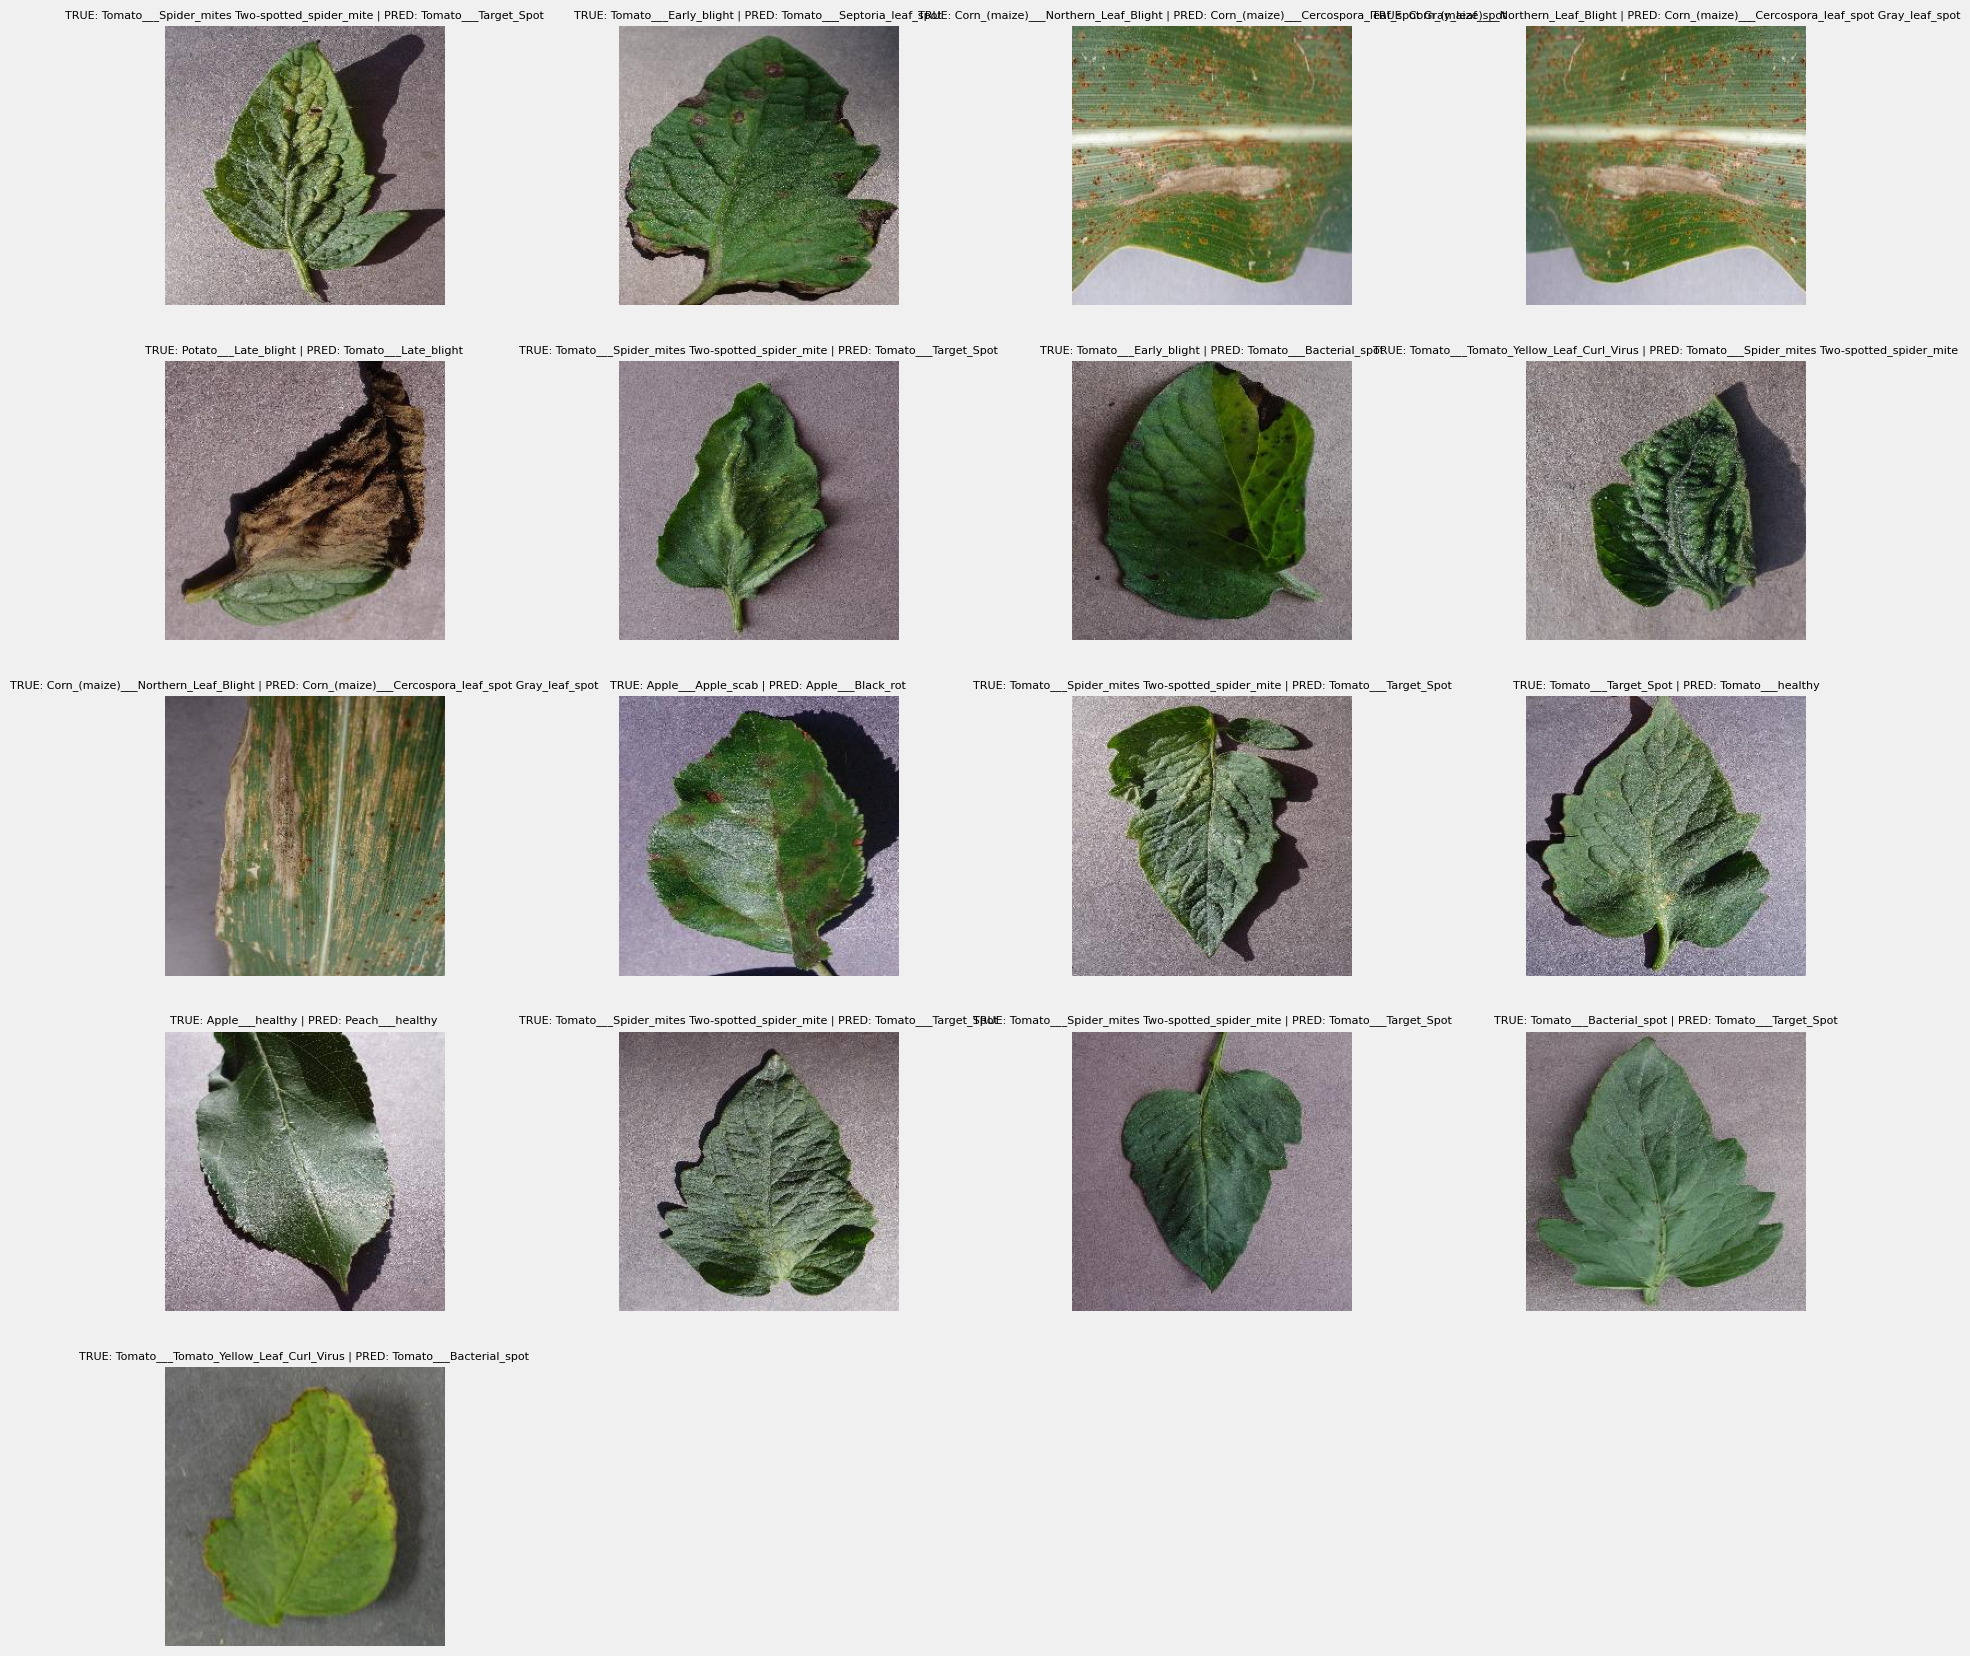

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

# Print the most confident errors

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())
# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)
plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()